In [1]:
import tensorflow as tf

2023-08-24 19:53:35.772999: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-24 19:53:35.801660: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-24 19:53:37.101384: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.__version__

'2.13.0'

In [3]:
import glob
# import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
# from tensorflow.python.keras import layers
from tensorflow.keras import layers, activations
import time
import nibabel as nib
from tqdm import tqdm
import gc
from scipy.ndimage import binary_erosion
from IPython import display
import datetime

import model

In [4]:
subjects = [ f.name for f in os.scandir('./Data') if f.is_dir() and f.name != '.ipynb_checkpoints']

# subjects = ['390645', '120111']

e_or_o = 0

p_size_i = 16
p_size_o = p_size_i

print(subjects)

['390645', '545345', '106016', '120111', '101915', '351938', '705341']


In [5]:
subjects_lr = []
subjects_hr = []
subjects_masks = []

subjects_preproc_values_lr = []
subjects_preproc_values_hr = []

subjects_t1_preproc_values = []

for subj in subjects:

    h4_imgs = []
    h4_imgs_lr = []
    dti_imgs = []
    dti_imgs_lr = []

    # DTI normalisation metrics pre-normalisation (storing max and min values in the mask) - Store for HR only
    dti_preprocs_hr = np.zeros((6,2))
    dti_preprocs_lr = np.zeros((6,2))

    print("Loading Subject {}".format(subj))
    
    for i in range(1,9):
    
        dti_data = np.array(nib.load("Data/{}/T1w/Diffusion/dt_all_{}.nii".format(subj,i)).get_fdata())
        dti_data_lr = np.array(nib.load("Data/{}/T1w/Diffusion/dt_all_lowres_2_{}.nii".format(subj,i)).get_fdata())
    
        # if i > 1:
        #     dti_data[dti_imgs[0] < 0] = 0
        #     dti_data_lr[dti_imgs[0] < 0] = 0
    
        dti_imgs.append(dti_data)
        dti_imgs_lr.append(dti_data_lr)
    
        dti_data = None
        dti_data_lr = None
    
    for i in range(1,25):
    
        h4_data = np.array(nib.load("Data/{}/T1w/Diffusion/h4_all_{}.nii".format(subj,str(i).zfill(2))).get_fdata())
        h4_data_lr = np.array(nib.load("Data/{}/T1w/Diffusion/h4_all_lowres_2_{}.nii".format(subj,str(i).zfill(2))).get_fdata())
    
        # if i > 1:
        #     h4_data[h4_data[0] < 0] = 0
        #     h4_data_lr[h4_data[0] < 0] = 0
        
        h4_imgs.append(h4_data)
        h4_imgs_lr.append(h4_data_lr)
    
        h4_data = None
        h4_data_lr = None
    
    h4_imgs = np.array(h4_imgs).transpose((1,2,3,0))
    h4_imgs_lr = np.array(h4_imgs_lr).transpose((1,2,3,0))
    
    dti_imgs = np.array(dti_imgs).transpose((1,2,3,0))
    dti_imgs_lr = np.array(dti_imgs_lr).transpose((1,2,3,0))
    
    mask = h4_imgs[...,0]

    binmask = np.zeros(mask.shape)

    binmask[mask >= 0] = 1

    mask = binary_erosion(binmask, structure=np.ones((5,5,5),np.uint8),iterations = 1)

    binmask = None

    # Calculate DTI ranges and normalise to range [0,1]
    for i in range(2,8):

        dti_preprocs_lr[i-2,:] = np.array([np.min(mask*dti_imgs_lr[...,i]), np.max(mask*dti_imgs_lr[...,i])])
        dti_imgs_lr[mask>0, i] = (dti_imgs_lr[mask>0, i] - dti_preprocs_lr[i-2,0] + 0.0001) / (dti_preprocs_lr[i-2,1] - dti_preprocs_lr[i-2,0])
        dti_imgs_lr[mask==0, i] = 0

        dti_preprocs_hr[i-2,:] = np.array([np.min(mask*dti_imgs[...,i]), np.max(mask*dti_imgs[...,i])])
        dti_imgs[mask>0, i] = (dti_imgs[mask>0, i] - dti_preprocs_hr[i-2,0] + 0.0001) / (dti_preprocs_hr[i-2,1] - dti_preprocs_hr[i-2,0])
        dti_imgs[mask==0, i] = 0


    t1w = nib.load("Data/{}/T1w/Diffusion/t1w.nii".format(subj))
    
    t1w_data = np.array(t1w.get_fdata())
    
    t1w_data_format = np.concatenate(
        (t1w_data[::2,::2,::2, None], t1w_data[::2,::2,1::2, None],
         t1w_data[::2,1::2,::2, None], t1w_data[::2,1::2,1::2, None],
         t1w_data[1::2,::2,::2, None], t1w_data[1::2,::2,1::2, None],
         t1w_data[1::2,1::2,::2, None], t1w_data[1::2,1::2,1::2, None]),
        axis=-1)

    t1w_preprocs = np.array([np.min(t1w_data_format*mask[...,None]), np.max(t1w_data_format*mask[...,None])])
    
    subjects_t1_preproc_values.append(t1w_preprocs)    
    t1w_data_format[mask>0, :] = (t1w_data_format[mask>0, :] - t1w_preprocs[0] + 0.0001) / (t1w_preprocs[1] - t1w_preprocs[0])

    subjects_preproc_values_lr.append(dti_preprocs_lr)
    subjects_preproc_values_hr.append(dti_preprocs_hr)

    lowres_input = np.concatenate((dti_imgs_lr[...,2:], t1w_data_format), axis=-1)
    hires_output = np.copy(dti_imgs[...,2:])
    
    # lowres_input = np.concatenate((h4_imgs_lr[...,2:], dti_imgs_lr[...,2:], t1w_data_format), axis=-1)
    # hires_output = np.copy(h4_imgs[...,2:])

    subjects_lr.append(lowres_input)
    subjects_hr.append(hires_output)
    subjects_masks.append(mask)


Loading Subject 390645
Loading Subject 545345
Loading Subject 106016
Loading Subject 120111
Loading Subject 101915
Loading Subject 351938
Loading Subject 705341


In [6]:
input_layer = tf.keras.Input(shape=(2*p_size_i, 2*p_size_i, 2*p_size_i, 14))
output_layer = model.unet3d(input_layer, 50, 6)

# output_layer = tf.keras.activations.sigmoid(output_layer)

model_unet = tf.keras.Model(input_layer, output_layer)

2023-08-24 19:53:55.473045: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-24 19:53:55.489205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-24 19:53:55.489310: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
print(model_unet.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 32, 14)]     0         []                            
                                                                                                  
 conv3d (Conv3D)             (None, 32, 32, 32, 50)       18950     ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 32, 50)       200       ['conv3d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv3d_1 (Conv3D)           (None, 32, 32, 32, 50)       67550     ['batch_normalization[0][0

In [8]:
# cross_entropy = tf.keras.losses.BinaryCrossentropy()

def model_loss(output, target):
    # return cross_entropy(output, target)
    return tf.reduce_mean(tf.square(target - output))

In [9]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=50*200,
    decay_rate=0.1
)

model_optimizer = tf.keras.optimizers.Adam(lr_schedule)

In [10]:
checkpoint_dir = './training_checkpoints_unet'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(model_optimizer=model_optimizer,
                                 model=model_unet)

loss_metric = tf.keras.metrics.Mean('model_loss', dtype=tf.float32)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = './logs/unet3d/' + current_time + '/train'
summary_writer = tf.summary.create_file_writer(log_dir)

In [11]:
@tf.function
def train_step(lr_patch, hr_patch):

    with tf.GradientTape() as model_tape:

      output = model_unet(lr_patch, training=True)

      m_loss = model_loss(output, hr_patch)

      loss_metric(m_loss)

    gradients_of_model = model_tape.gradient(m_loss, model_unet.trainable_variables)

    model_optimizer.apply_gradients(zip(gradients_of_model, model_unet.trainable_variables))

    return m_loss

In [12]:
def train(data, epochs):

  best_cost = np.Inf
  
  for epoch in range(epochs):
    start = time.time()

    print("Epoch: {}".format(epoch+1))

    print("Learning rate:", model_optimizer.learning_rate.numpy())

    mean_m_loss = 0.0

    # [sel_indices, subjects_lr, subjects_hr, subjects_masks]

    randsels = np.random.choice(data[0].shape[0],data[0].shape[0]//4)

    lr_patches = []
    hr_patches = []

    for prog, index in enumerate(tqdm(randsels)):

        if (prog+1) % 8 != 0 and prog != (len(randsels) - 1):

            (s, i, j, k) = data[0][index]
        
            lr_patch = np.copy(data[1][s][
                                    i - p_size_i - e_or_o : i + p_size_i,
                                    j - p_size_i - e_or_o : j + p_size_i,
                                    k - p_size_i - e_or_o : k + p_size_i, :]) * \
            np.copy(data[3][s][
                                    i - p_size_i - e_or_o : i + p_size_i,
                                    j - p_size_i - e_or_o : j + p_size_i,
                                    k - p_size_i - e_or_o : k + p_size_i, None])
                               
        
            hr_patch = np.copy(data[2][s][
                                    i - p_size_o - e_or_o : i + p_size_o,
                                    j - p_size_o - e_or_o : j + p_size_o,
                                    k - p_size_o - e_or_o : k + p_size_o, :]) * \
            np.copy(data[3][s][
                                    i - p_size_o - e_or_o : i + p_size_o,
                                    j - p_size_o - e_or_o : j + p_size_o,
                                    k - p_size_o - e_or_o : k + p_size_o, None])

            lr_patches.append(lr_patch)
            hr_patches.append(hr_patch)
            
            continue
        
        lr_patches = tf.convert_to_tensor(np.array(lr_patches), dtype=tf.float32)
        hr_patches = tf.convert_to_tensor(np.array(hr_patches), dtype=tf.float32)
        
        m_loss = train_step(lr_patches, hr_patches)

        with summary_writer.as_default():
            tf.summary.scalar('model_loss', loss_metric.result(), step=epoch)
        
        mean_m_loss = mean_m_loss + m_loss

        lr_patches = []
        hr_patches = []

    if epoch+1 % 5 == 0 and best_cost < mean_m_loss:
        checkpoint.save(file_prefix = checkpoint_prefix)
        best_cost = total_cost

    print('Model Loss is {}'.format(float(mean_m_loss/len(randsels//8))))
      
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

In [13]:
(xsize, ysize, zsize, comp) = subjects_lr[0].shape

# e_or_o = 0

# p_size_i = 16
# p_size_o = 16

# split_indices = [(i, j, k)
#                  for k in np.arange(p_size_i+1,zsize-p_size_i+1,2*p_size_o+1)       
#                  for j in np.arange(p_size_i+1,ysize-p_size_i+1,2*p_size_o+1)
#                  for i in np.arange(p_size_i+1,xsize-p_size_i+1,2*p_size_o+1)
#                 ]

split_indices = [(i, j, k)
                 for k in np.arange(p_size_i+e_or_o,zsize-p_size_i+e_or_o,2*p_size_o+e_or_o)       
                 for j in np.arange(p_size_i+e_or_o,ysize-p_size_i+e_or_o,2*p_size_o+e_or_o)
                 for i in np.arange(p_size_i+e_or_o,xsize-p_size_i+e_or_o,2*p_size_o+e_or_o)
                ]

sel_indices = []

for s in range(len(subjects_lr)):
    for (i, j, k) in split_indices:
        ipatch_mask = subjects_masks[s][
            i - p_size_o - e_or_o : i + p_size_o,
            j - p_size_o - e_or_o : j + p_size_o,
            k - p_size_o - e_or_o : k + p_size_o]
    
        if np.max(ipatch_mask) > 0:
            sel_indices.append((s,i,j,k))

sel_indices = np.array(sel_indices)

In [14]:
train([sel_indices, subjects_lr, subjects_hr, subjects_masks], 300)

Epoch: 1
Learning rate: 0.001


  0%|                                                   | 0/103 [00:00<?, ?it/s]2023-08-24 19:54:01.713856: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-24 19:54:04.284496: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f730e584de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-24 19:54:04.284524: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090 Ti, Compute Capability 8.6
2023-08-24 19:54:04.290167: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-08-24 19:54:04.524620: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|█████████████████████████████████████████| 103/103 [00:24<00:00,  4.15it/s]


Model Loss is 0.08353915065526962
Time for epoch 1 is 24.816176414489746 sec
Epoch: 2
Learning rate: 0.0009944891


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.61it/s]


Model Loss is 0.009028344415128231
Time for epoch 2 is 1.8541874885559082 sec
Epoch: 3
Learning rate: 0.0009885532


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.73it/s]


Model Loss is 0.00534519599750638
Time for epoch 3 is 1.8500804901123047 sec
Epoch: 4
Learning rate: 0.0009826525


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.35it/s]


Model Loss is 0.003144401591271162
Time for epoch 4 is 1.8631501197814941 sec
Epoch: 5
Learning rate: 0.0009767873


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.63it/s]


Model Loss is 0.003273224690929055
Time for epoch 5 is 1.8533055782318115 sec
Epoch: 6
Learning rate: 0.00097095704


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.48it/s]


Model Loss is 0.0022810366936028004
Time for epoch 6 is 1.8582508563995361 sec
Epoch: 7
Learning rate: 0.0009651616


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.60it/s]


Model Loss is 0.001782718114554882
Time for epoch 7 is 1.85404372215271 sec
Epoch: 8
Learning rate: 0.0009594006


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 56.67it/s]


Model Loss is 0.0020750442054122686
Time for epoch 8 is 1.8190419673919678 sec
Epoch: 9
Learning rate: 0.0009536742


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 59.22it/s]


Model Loss is 0.0017053191550076008
Time for epoch 9 is 1.7408599853515625 sec
Epoch: 10
Learning rate: 0.00094798184


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.82it/s]


Model Loss is 0.002174423774704337
Time for epoch 10 is 1.7524323463439941 sec
Epoch: 11
Learning rate: 0.00094232353


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 59.27it/s]


Model Loss is 0.0017443947726860642
Time for epoch 11 is 1.7391736507415771 sec
Epoch: 12
Learning rate: 0.0009366989


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.65it/s]


Model Loss is 0.0014948834432289004
Time for epoch 12 is 1.7576851844787598 sec
Epoch: 13
Learning rate: 0.0009311079


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.97it/s]


Model Loss is 0.0014558808179572225
Time for epoch 13 is 1.7480254173278809 sec
Epoch: 14
Learning rate: 0.00092555024


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.50it/s]


Model Loss is 0.0018732708413153887
Time for epoch 14 is 1.7621877193450928 sec
Epoch: 15
Learning rate: 0.0009200258


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.50it/s]


Model Loss is 0.0016502020880579948
Time for epoch 15 is 1.7621264457702637 sec
Epoch: 16
Learning rate: 0.0009145343


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.33it/s]


Model Loss is 0.0013825728092342615
Time for epoch 16 is 1.7674145698547363 sec
Epoch: 17
Learning rate: 0.0009090756


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.63it/s]


Model Loss is 0.0016067764954641461
Time for epoch 17 is 1.7582011222839355 sec
Epoch: 18
Learning rate: 0.0009036495


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.57it/s]


Model Loss is 0.0017568693729117513
Time for epoch 18 is 1.7598447799682617 sec
Epoch: 19
Learning rate: 0.00089825573


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.77it/s]


Model Loss is 0.001002032426185906
Time for epoch 19 is 1.7538459300994873 sec
Epoch: 20
Learning rate: 0.0008928942


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.04it/s]


Model Loss is 0.001108804251998663
Time for epoch 20 is 1.776165246963501 sec
Epoch: 21
Learning rate: 0.0008875646


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 59.51it/s]


Model Loss is 0.0013370095985010266
Time for epoch 21 is 1.7320740222930908 sec
Epoch: 22
Learning rate: 0.0008822669


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 59.14it/s]


Model Loss is 0.0011347875697538257
Time for epoch 22 is 1.743051528930664 sec
Epoch: 23
Learning rate: 0.00087700086


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 59.12it/s]


Model Loss is 0.0013408774975687265
Time for epoch 23 is 1.743626594543457 sec
Epoch: 24
Learning rate: 0.0008717662


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 56.83it/s]


Model Loss is 0.001012631575576961
Time for epoch 24 is 1.8142035007476807 sec
Epoch: 25
Learning rate: 0.00086656277


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 56.74it/s]


Model Loss is 0.0017616297118365765
Time for epoch 25 is 1.8169264793395996 sec
Epoch: 26
Learning rate: 0.0008613904


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 59.31it/s]


Model Loss is 0.0010226201266050339
Time for epoch 26 is 1.7381680011749268 sec
Epoch: 27
Learning rate: 0.00085624884


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 59.20it/s]


Model Loss is 0.0011284390930086374
Time for epoch 27 is 1.7411761283874512 sec
Epoch: 28
Learning rate: 0.0008511381


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.04it/s]


Model Loss is 0.0009915180271491408
Time for epoch 28 is 1.8071198463439941 sec
Epoch: 29
Learning rate: 0.0008460578


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 56.26it/s]


Model Loss is 0.0009196757455356419
Time for epoch 29 is 1.8325295448303223 sec
Epoch: 30
Learning rate: 0.0008410078


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 56.65it/s]


Model Loss is 0.0012844298034906387
Time for epoch 30 is 1.8201918601989746 sec
Epoch: 31
Learning rate: 0.0008359879


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 56.94it/s]


Model Loss is 0.0009386626188643277
Time for epoch 31 is 1.810692310333252 sec
Epoch: 32
Learning rate: 0.0008309981


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.04it/s]


Model Loss is 0.0011625367915257812
Time for epoch 32 is 1.8073883056640625 sec
Epoch: 33
Learning rate: 0.00082603795


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.23it/s]


Model Loss is 0.0009932753164321184
Time for epoch 33 is 1.8012888431549072 sec
Epoch: 34
Learning rate: 0.00082110753


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.19it/s]


Model Loss is 0.0008611929952166975
Time for epoch 34 is 1.8024189472198486 sec
Epoch: 35
Learning rate: 0.0008162064


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.09it/s]


Model Loss is 0.0007189887692220509
Time for epoch 35 is 1.805532693862915 sec
Epoch: 36
Learning rate: 0.00081133464


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.02it/s]


Model Loss is 0.001891274587251246
Time for epoch 36 is 1.8077664375305176 sec
Epoch: 37
Learning rate: 0.0008064919


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 53.53it/s]


Model Loss is 0.0014789000852033496
Time for epoch 37 is 1.9256782531738281 sec
Epoch: 38
Learning rate: 0.00080167816


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 53.54it/s]


Model Loss is 0.0009881147416308522
Time for epoch 38 is 1.9256408214569092 sec
Epoch: 39
Learning rate: 0.000796893


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 53.79it/s]


Model Loss is 0.0007788452203385532
Time for epoch 39 is 1.9166712760925293 sec
Epoch: 40
Learning rate: 0.00079213653


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 53.29it/s]


Model Loss is 0.0008936544181779027
Time for epoch 40 is 1.934962511062622 sec
Epoch: 41
Learning rate: 0.0007874083


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 53.53it/s]


Model Loss is 0.0009501418680883944
Time for epoch 41 is 1.926314115524292 sec
Epoch: 42
Learning rate: 0.00078270846


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 53.45it/s]


Model Loss is 0.001022885087877512
Time for epoch 42 is 1.9289164543151855 sec
Epoch: 43
Learning rate: 0.0007780366


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.81it/s]


Model Loss is 0.001099271234124899
Time for epoch 43 is 1.8476612567901611 sec
Epoch: 44
Learning rate: 0.0007733927


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.88it/s]


Model Loss is 0.0009333673515357077
Time for epoch 44 is 1.8454723358154297 sec
Epoch: 45
Learning rate: 0.00076877634


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.64it/s]


Model Loss is 0.001181738800369203
Time for epoch 45 is 1.8533012866973877 sec
Epoch: 46
Learning rate: 0.00076418766


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.92it/s]


Model Loss is 0.0011748478282243013
Time for epoch 46 is 1.843648910522461 sec
Epoch: 47
Learning rate: 0.00075962633


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.32it/s]


Model Loss is 0.0011292215203866363
Time for epoch 47 is 1.8639988899230957 sec
Epoch: 48
Learning rate: 0.0007550923


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.17it/s]


Model Loss is 0.0013225771253928542
Time for epoch 48 is 1.8691213130950928 sec
Epoch: 49
Learning rate: 0.0007505852


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.46it/s]


Model Loss is 0.0009385981829836965
Time for epoch 49 is 1.859419584274292 sec
Epoch: 50
Learning rate: 0.0007461051


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.38it/s]


Model Loss is 0.0011922754347324371
Time for epoch 50 is 1.8617780208587646 sec
Epoch: 51
Learning rate: 0.00074165175


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.29it/s]


Model Loss is 0.0013509279815480113
Time for epoch 51 is 1.768852949142456 sec
Epoch: 52
Learning rate: 0.000737225


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.86it/s]


Model Loss is 0.0007883685175329447
Time for epoch 52 is 1.7516305446624756 sec
Epoch: 53
Learning rate: 0.0007328246


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.98it/s]


Model Loss is 0.0009512000251561403
Time for epoch 53 is 1.7482142448425293 sec
Epoch: 54
Learning rate: 0.0007284505


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.73it/s]


Model Loss is 0.0013719010166823864
Time for epoch 54 is 1.7858757972717285 sec
Epoch: 55
Learning rate: 0.0007241025


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.54it/s]


Model Loss is 0.0009560445905663073
Time for epoch 55 is 1.761124849319458 sec
Epoch: 56
Learning rate: 0.0007197804


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.44it/s]


Model Loss is 0.000716262380592525
Time for epoch 56 is 1.764167070388794 sec
Epoch: 57
Learning rate: 0.0007154842


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 59.13it/s]


Model Loss is 0.0009260154911316931
Time for epoch 57 is 1.7434427738189697 sec
Epoch: 58
Learning rate: 0.0007112135


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.65it/s]


Model Loss is 0.0008519878028891981
Time for epoch 58 is 1.7579066753387451 sec
Epoch: 59
Learning rate: 0.0007069684


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 59.06it/s]


Model Loss is 0.0007458243053406477
Time for epoch 59 is 1.7457005977630615 sec
Epoch: 60
Learning rate: 0.00070274866


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.67it/s]


Model Loss is 0.0005262737977318466
Time for epoch 60 is 1.7567310333251953 sec
Epoch: 61
Learning rate: 0.0006985541


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.12it/s]


Model Loss is 0.0007408735691569746
Time for epoch 61 is 1.7737505435943604 sec
Epoch: 62
Learning rate: 0.0006943845


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.22it/s]


Model Loss is 0.000575816840864718
Time for epoch 62 is 1.8670637607574463 sec
Epoch: 63
Learning rate: 0.0006902399


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.46it/s]


Model Loss is 0.0012610792182385921
Time for epoch 63 is 1.8587243556976318 sec
Epoch: 64
Learning rate: 0.0006861199


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.38it/s]


Model Loss is 0.0009707278222776949
Time for epoch 64 is 1.8614239692687988 sec
Epoch: 65
Learning rate: 0.0006820246


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.46it/s]


Model Loss is 0.0007717287517152727
Time for epoch 65 is 1.8587310314178467 sec
Epoch: 66
Learning rate: 0.00067795365


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.13it/s]


Model Loss is 0.001164593966677785
Time for epoch 66 is 1.8698029518127441 sec
Epoch: 67
Learning rate: 0.00067390705


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.34it/s]


Model Loss is 0.0009533688426017761
Time for epoch 67 is 1.8630249500274658 sec
Epoch: 68
Learning rate: 0.00066988467


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.44it/s]


Model Loss is 0.0006879914435558021
Time for epoch 68 is 1.859743595123291 sec
Epoch: 69
Learning rate: 0.0006658862


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.74it/s]


Model Loss is 0.0006290038581937551
Time for epoch 69 is 1.8495333194732666 sec
Epoch: 70
Learning rate: 0.0006619116


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.18it/s]


Model Loss is 0.0008216786081902683
Time for epoch 70 is 1.8683195114135742 sec
Epoch: 71
Learning rate: 0.0006579608


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.86it/s]


Model Loss is 0.0005266356165520847
Time for epoch 71 is 1.845261812210083 sec
Epoch: 72
Learning rate: 0.0006540335


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.20it/s]


Model Loss is 0.0007213085191324353
Time for epoch 72 is 1.867506980895996 sec
Epoch: 73
Learning rate: 0.0006501297


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.37it/s]


Model Loss is 0.0005988190532661974
Time for epoch 73 is 1.8623592853546143 sec
Epoch: 74
Learning rate: 0.0006462492


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.12it/s]


Model Loss is 0.0006849711644463241
Time for epoch 74 is 1.8707773685455322 sec
Epoch: 75
Learning rate: 0.0006423919


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.43it/s]


Model Loss is 0.0007054675370454788
Time for epoch 75 is 1.85970139503479 sec
Epoch: 76
Learning rate: 0.00063855754


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.01it/s]


Model Loss is 0.0006674207397736609
Time for epoch 76 is 1.8740851879119873 sec
Epoch: 77
Learning rate: 0.0006347461


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.81it/s]


Model Loss is 0.0008137152763083577
Time for epoch 77 is 1.7831299304962158 sec
Epoch: 78
Learning rate: 0.0006309574


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.71it/s]


Model Loss is 0.0006925100460648537
Time for epoch 78 is 1.7555365562438965 sec
Epoch: 79
Learning rate: 0.0006271913


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.87it/s]


Model Loss is 0.0006169325206428766
Time for epoch 79 is 1.7507696151733398 sec
Epoch: 80
Learning rate: 0.0006234477


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.38it/s]


Model Loss is 0.0005814226460643113
Time for epoch 80 is 1.7658674716949463 sec
Epoch: 81
Learning rate: 0.00061972643


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 56.58it/s]


Model Loss is 0.0008053580531850457
Time for epoch 81 is 1.8221487998962402 sec
Epoch: 82
Learning rate: 0.0006160274


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.42it/s]


Model Loss is 0.0007816501311026514
Time for epoch 82 is 1.795457363128662 sec
Epoch: 83
Learning rate: 0.0006123504


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.58it/s]


Model Loss is 0.0007389133097603917
Time for epoch 83 is 1.7598106861114502 sec
Epoch: 84
Learning rate: 0.00060869544


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.31it/s]


Model Loss is 0.0005155803519301116
Time for epoch 84 is 1.7677760124206543 sec
Epoch: 85
Learning rate: 0.0006050622


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.59it/s]


Model Loss is 0.0006267477874644101
Time for epoch 85 is 1.7595865726470947 sec
Epoch: 86
Learning rate: 0.00060145074


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.59it/s]


Model Loss is 0.0007695541135035455
Time for epoch 86 is 1.7592856884002686 sec
Epoch: 87
Learning rate: 0.0005978607


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.59it/s]


Model Loss is 0.00048055240768007934
Time for epoch 87 is 1.7592012882232666 sec
Epoch: 88
Learning rate: 0.0005942922


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.98it/s]


Model Loss is 0.0008423849358223379
Time for epoch 88 is 1.778334379196167 sec
Epoch: 89
Learning rate: 0.00059074495


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.43it/s]


Model Loss is 0.0008394381147809327
Time for epoch 89 is 1.7644131183624268 sec
Epoch: 90
Learning rate: 0.0005872189


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.49it/s]


Model Loss is 0.0007241013227030635
Time for epoch 90 is 1.7627465724945068 sec
Epoch: 91
Learning rate: 0.0005837139


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.80it/s]


Model Loss is 0.0005262094200588763
Time for epoch 91 is 1.7535936832427979 sec
Epoch: 92
Learning rate: 0.0005802298


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.42it/s]


Model Loss is 0.0004671527713071555
Time for epoch 92 is 1.7649736404418945 sec
Epoch: 93
Learning rate: 0.00057676644


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.50it/s]


Model Loss is 0.0006831435021013021
Time for epoch 93 is 1.7622196674346924 sec
Epoch: 94
Learning rate: 0.00057332386


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.27it/s]


Model Loss is 0.0004096852499060333
Time for epoch 94 is 1.7696685791015625 sec
Epoch: 95
Learning rate: 0.0005699018


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.51it/s]


Model Loss is 0.00045907514868304133
Time for epoch 95 is 1.7622857093811035 sec
Epoch: 96
Learning rate: 0.0005665002


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.18it/s]


Model Loss is 0.0005316665046848357
Time for epoch 96 is 1.771946668624878 sec
Epoch: 97
Learning rate: 0.0005631188


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.43it/s]


Model Loss is 0.0005973700317554176
Time for epoch 97 is 1.7647285461425781 sec
Epoch: 98
Learning rate: 0.00055975764


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.13it/s]


Model Loss is 0.0004948627320118248
Time for epoch 98 is 1.7737314701080322 sec
Epoch: 99
Learning rate: 0.0005564165


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.62it/s]


Model Loss is 0.000403972138883546
Time for epoch 99 is 1.7890996932983398 sec
Epoch: 100
Learning rate: 0.0005530953


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 59.38it/s]


Model Loss is 0.0005107374163344502
Time for epoch 100 is 1.7362611293792725 sec
Epoch: 101
Learning rate: 0.00054979406


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.81it/s]


Model Loss is 0.0004992619506083429
Time for epoch 101 is 1.7833361625671387 sec
Epoch: 102
Learning rate: 0.00054651237


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.35it/s]


Model Loss is 0.0003729343879967928
Time for epoch 102 is 1.7663984298706055 sec
Epoch: 103
Learning rate: 0.00054325035


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.51it/s]


Model Loss is 0.0003766226873267442
Time for epoch 103 is 1.7615997791290283 sec
Epoch: 104
Learning rate: 0.0005400077


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.37it/s]


Model Loss is 0.00045320639037527144
Time for epoch 104 is 1.7662787437438965 sec
Epoch: 105
Learning rate: 0.00053678453


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.78it/s]


Model Loss is 0.000545748567674309
Time for epoch 105 is 1.7839117050170898 sec
Epoch: 106
Learning rate: 0.00053358055


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.54it/s]


Model Loss is 0.0004485313838813454
Time for epoch 106 is 1.791236162185669 sec
Epoch: 107
Learning rate: 0.0005303958


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.35it/s]


Model Loss is 0.0005055380170233548
Time for epoch 107 is 1.7664666175842285 sec
Epoch: 108
Learning rate: 0.00052722986


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.10it/s]


Model Loss is 0.0004384630883578211
Time for epoch 108 is 1.8709464073181152 sec
Epoch: 109
Learning rate: 0.0005240829


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 54.04it/s]


Model Loss is 0.0005929121980443597
Time for epoch 109 is 1.9079818725585938 sec
Epoch: 110
Learning rate: 0.0005209548


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 51.81it/s]


Model Loss is 0.0006732837064191699
Time for epoch 110 is 1.989311933517456 sec
Epoch: 111
Learning rate: 0.0005178452


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 53.87it/s]


Model Loss is 0.0006772882770746946
Time for epoch 111 is 1.913083791732788 sec
Epoch: 112
Learning rate: 0.0005147543


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.58it/s]


Model Loss is 0.0006114623392932117
Time for epoch 112 is 1.854851245880127 sec
Epoch: 113
Learning rate: 0.0005116819


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.22it/s]


Model Loss is 0.0004422820929903537
Time for epoch 113 is 1.8671424388885498 sec
Epoch: 114
Learning rate: 0.0005086277


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.13it/s]


Model Loss is 0.00039960729191079736
Time for epoch 114 is 1.8699815273284912 sec
Epoch: 115
Learning rate: 0.0005055918


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.55it/s]


Model Loss is 0.0005335959140211344
Time for epoch 115 is 1.8556227684020996 sec
Epoch: 116
Learning rate: 0.00050257397


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.71it/s]


Model Loss is 0.0004882857901975513
Time for epoch 116 is 1.8506121635437012 sec
Epoch: 117
Learning rate: 0.00049957423


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 56.14it/s]


Model Loss is 0.0005767333204858005
Time for epoch 117 is 1.8363134860992432 sec
Epoch: 118
Learning rate: 0.0004965923


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.83it/s]


Model Loss is 0.00046798106632195413
Time for epoch 118 is 1.846482753753662 sec
Epoch: 119
Learning rate: 0.00049362826


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 56.23it/s]


Model Loss is 0.0006512406398542225
Time for epoch 119 is 1.833512783050537 sec
Epoch: 120
Learning rate: 0.00049068185


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.66it/s]


Model Loss is 0.0005329987616278231
Time for epoch 120 is 1.8524422645568848 sec
Epoch: 121
Learning rate: 0.00048775307


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.80it/s]


Model Loss is 0.0004468772385735065
Time for epoch 121 is 1.8476061820983887 sec
Epoch: 122
Learning rate: 0.0004848418


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.33it/s]


Model Loss is 0.0005464386194944382
Time for epoch 122 is 1.8633716106414795 sec
Epoch: 123
Learning rate: 0.0004819478


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.60it/s]


Model Loss is 0.001688017975538969
Time for epoch 123 is 1.854076623916626 sec
Epoch: 124
Learning rate: 0.0004790712


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.76it/s]


Model Loss is 0.0011388779385015368
Time for epoch 124 is 1.8489744663238525 sec
Epoch: 125
Learning rate: 0.0004762116


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 56.14it/s]


Model Loss is 0.0014534759102389216
Time for epoch 125 is 1.8362598419189453 sec
Epoch: 126
Learning rate: 0.00047336923


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.52it/s]


Model Loss is 0.00144974107388407
Time for epoch 126 is 1.8569684028625488 sec
Epoch: 127
Learning rate: 0.00047054375


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.46it/s]


Model Loss is 0.0009914698312059045
Time for epoch 127 is 1.8592047691345215 sec
Epoch: 128
Learning rate: 0.0004677352


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.25it/s]


Model Loss is 0.000862825196236372
Time for epoch 128 is 1.9734716415405273 sec
Epoch: 129
Learning rate: 0.00046494335


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.36it/s]


Model Loss is 0.0008459662785753608
Time for epoch 129 is 1.9698479175567627 sec
Epoch: 130
Learning rate: 0.0004621682


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.16it/s]


Model Loss is 0.0008203767938539386
Time for epoch 130 is 1.9768505096435547 sec
Epoch: 131
Learning rate: 0.00045940955


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.28it/s]


Model Loss is 0.0008734271978028119
Time for epoch 131 is 1.9730744361877441 sec
Epoch: 132
Learning rate: 0.00045666745


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.23it/s]


Model Loss is 0.0006979235913604498
Time for epoch 132 is 1.9741413593292236 sec
Epoch: 133
Learning rate: 0.00045394167


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.89it/s]


Model Loss is 0.0007858712342567742
Time for epoch 133 is 1.9492087364196777 sec
Epoch: 134
Learning rate: 0.00045123216


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.62it/s]


Model Loss is 0.0009084969060495496
Time for epoch 134 is 1.959233045578003 sec
Epoch: 135
Learning rate: 0.0004485388


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.76it/s]


Model Loss is 0.0010137141216546297
Time for epoch 135 is 1.9542415142059326 sec
Epoch: 136
Learning rate: 0.0004458616


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.57it/s]


Model Loss is 0.0007147915312089026
Time for epoch 136 is 1.9615294933319092 sec
Epoch: 137
Learning rate: 0.0004432003


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.81it/s]


Model Loss is 0.000455498811788857
Time for epoch 137 is 1.9522533416748047 sec
Epoch: 138
Learning rate: 0.0004405549


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.53it/s]


Model Loss is 0.0005923561402596533
Time for epoch 138 is 1.9627249240875244 sec
Epoch: 139
Learning rate: 0.0004379253


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.80it/s]


Model Loss is 0.0006057327846065164
Time for epoch 139 is 1.9524359703063965 sec
Epoch: 140
Learning rate: 0.00043531138


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.45it/s]


Model Loss is 0.0005377399502322078
Time for epoch 140 is 1.96563720703125 sec
Epoch: 141
Learning rate: 0.0004327131


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.77it/s]


Model Loss is 0.0005557890981435776
Time for epoch 141 is 1.9533164501190186 sec
Epoch: 142
Learning rate: 0.00043013028


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.57it/s]


Model Loss is 0.0004865978262387216
Time for epoch 142 is 1.960738182067871 sec
Epoch: 143
Learning rate: 0.00042756292


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.76it/s]


Model Loss is 0.0004773512773681432
Time for epoch 143 is 1.9540112018585205 sec
Epoch: 144
Learning rate: 0.00042501086


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.41it/s]


Model Loss is 0.00045631578541360795
Time for epoch 144 is 1.9676587581634521 sec
Epoch: 145
Learning rate: 0.00042247406


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.81it/s]


Model Loss is 0.00045332807349041104
Time for epoch 145 is 1.952132225036621 sec
Epoch: 146
Learning rate: 0.00041995235


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.38it/s]


Model Loss is 0.0003731529868673533
Time for epoch 146 is 1.968120813369751 sec
Epoch: 147
Learning rate: 0.00041744573


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.66it/s]


Model Loss is 0.0004842819180339575
Time for epoch 147 is 1.9574108123779297 sec
Epoch: 148
Learning rate: 0.00041495406


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.35it/s]


Model Loss is 0.0005338461487554014
Time for epoch 148 is 1.9689643383026123 sec
Epoch: 149
Learning rate: 0.00041247727


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.64it/s]


Model Loss is 0.000500810332596302
Time for epoch 149 is 1.9584712982177734 sec
Epoch: 150
Learning rate: 0.0004100153


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.51it/s]


Model Loss is 0.000491788552608341
Time for epoch 150 is 1.9631843566894531 sec
Epoch: 151
Learning rate: 0.00040756798


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.86it/s]


Model Loss is 0.0005001223180443048
Time for epoch 151 is 1.950005292892456 sec
Epoch: 152
Learning rate: 0.00040513527


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.65it/s]


Model Loss is 0.00038999784737825394
Time for epoch 152 is 1.9577844142913818 sec
Epoch: 153
Learning rate: 0.00040271707


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.95it/s]


Model Loss is 0.0004969688598066568
Time for epoch 153 is 1.9466216564178467 sec
Epoch: 154
Learning rate: 0.0004003133


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.43it/s]


Model Loss is 0.00033393633202649653
Time for epoch 154 is 1.9661791324615479 sec
Epoch: 155
Learning rate: 0.0003979239


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.78it/s]


Model Loss is 0.0004475072491914034
Time for epoch 155 is 1.9530270099639893 sec
Epoch: 156
Learning rate: 0.00039554876


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.52it/s]


Model Loss is 0.0004329012881498784
Time for epoch 156 is 1.962641716003418 sec
Epoch: 157
Learning rate: 0.0003931878


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.72it/s]


Model Loss is 0.00038818668690510094
Time for epoch 157 is 1.955524206161499 sec
Epoch: 158
Learning rate: 0.0003908409


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 52.40it/s]


Model Loss is 0.0003854825918097049
Time for epoch 158 is 1.9673564434051514 sec
Epoch: 159
Learning rate: 0.00038850808


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.27it/s]


Model Loss is 0.00044106083805672824
Time for epoch 159 is 1.8648920059204102 sec
Epoch: 160
Learning rate: 0.00038618912


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.16it/s]


Model Loss is 0.0005719210603274405
Time for epoch 160 is 1.8683195114135742 sec
Epoch: 161
Learning rate: 0.00038388403


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.16it/s]


Model Loss is 0.0004632428754121065
Time for epoch 161 is 1.7724227905273438 sec
Epoch: 162
Learning rate: 0.0003815927


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.38it/s]


Model Loss is 0.0005976604879833758
Time for epoch 162 is 1.7961359024047852 sec
Epoch: 163
Learning rate: 0.00037931497


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.43it/s]


Model Loss is 0.0004752655222546309
Time for epoch 163 is 1.7637951374053955 sec
Epoch: 164
Learning rate: 0.00037705095


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.72it/s]


Model Loss is 0.00037085439544171095
Time for epoch 164 is 1.755086898803711 sec
Epoch: 165
Learning rate: 0.00037480038


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.83it/s]


Model Loss is 0.0004026360693387687
Time for epoch 165 is 1.7519640922546387 sec
Epoch: 166
Learning rate: 0.00037256326


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 59.52it/s]


Model Loss is 0.000443503464339301
Time for epoch 166 is 1.7318403720855713 sec
Epoch: 167
Learning rate: 0.00037033946


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 59.57it/s]


Model Loss is 0.00038474591565318406
Time for epoch 167 is 1.7303926944732666 sec
Epoch: 168
Learning rate: 0.000368129


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.37it/s]


Model Loss is 0.00036053196527063847
Time for epoch 168 is 1.7659099102020264 sec
Epoch: 169
Learning rate: 0.00036593166


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 56.86it/s]


Model Loss is 0.00035751613904722035
Time for epoch 169 is 1.8124830722808838 sec
Epoch: 170
Learning rate: 0.0003637475


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.41it/s]


Model Loss is 0.0004107717832084745
Time for epoch 170 is 1.7646944522857666 sec
Epoch: 171
Learning rate: 0.00036157636


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.74it/s]


Model Loss is 0.00037816210533492267
Time for epoch 171 is 1.7547976970672607 sec
Epoch: 172
Learning rate: 0.00035941822


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.20it/s]


Model Loss is 0.0004277306725271046
Time for epoch 172 is 1.7709474563598633 sec
Epoch: 173
Learning rate: 0.00035727283


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 59.27it/s]


Model Loss is 0.0005742753273807466
Time for epoch 173 is 1.739098072052002 sec
Epoch: 174
Learning rate: 0.00035514036


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.75it/s]


Model Loss is 0.000550806347746402
Time for epoch 174 is 1.7544007301330566 sec
Epoch: 175
Learning rate: 0.00035302056


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.96it/s]


Model Loss is 0.00035396782914176583
Time for epoch 175 is 1.7481491565704346 sec
Epoch: 176
Learning rate: 0.0003509135


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.42it/s]


Model Loss is 0.0003623466764111072
Time for epoch 176 is 1.7643444538116455 sec
Epoch: 177
Learning rate: 0.00034881892


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.57it/s]


Model Loss is 0.00037700534448958933
Time for epoch 177 is 1.7598075866699219 sec
Epoch: 178
Learning rate: 0.00034673687


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.63it/s]


Model Loss is 0.00034721344127319753
Time for epoch 178 is 1.7886323928833008 sec
Epoch: 179
Learning rate: 0.00034466726


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.58it/s]


Model Loss is 0.0003605219244491309
Time for epoch 179 is 1.7594692707061768 sec
Epoch: 180
Learning rate: 0.00034261003


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.19it/s]


Model Loss is 0.00036562862806022167
Time for epoch 180 is 1.7714242935180664 sec
Epoch: 181
Learning rate: 0.00034056502


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.76it/s]


Model Loss is 0.0002994106325786561
Time for epoch 181 is 1.7540180683135986 sec
Epoch: 182
Learning rate: 0.00033853226


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.86it/s]


Model Loss is 0.0004447154642548412
Time for epoch 182 is 1.781524419784546 sec
Epoch: 183
Learning rate: 0.0003365116


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.40it/s]


Model Loss is 0.0004495444300118834
Time for epoch 183 is 1.7650525569915771 sec
Epoch: 184
Learning rate: 0.00033450304


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.80it/s]


Model Loss is 0.00032377257593907416
Time for epoch 184 is 1.7832069396972656 sec
Epoch: 185
Learning rate: 0.0003325064


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.29it/s]


Model Loss is 0.00032906027627177536
Time for epoch 185 is 1.7683587074279785 sec
Epoch: 186
Learning rate: 0.00033052175


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.64it/s]


Model Loss is 0.0003403812588658184
Time for epoch 186 is 1.7880675792694092 sec
Epoch: 187
Learning rate: 0.00032854892


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.11it/s]


Model Loss is 0.00034972617868334055
Time for epoch 187 is 1.7738189697265625 sec
Epoch: 188
Learning rate: 0.00032658785


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.56it/s]


Model Loss is 0.0002722845529206097
Time for epoch 188 is 1.790714979171753 sec
Epoch: 189
Learning rate: 0.0003246385


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.28it/s]


Model Loss is 0.0004651542112696916
Time for epoch 189 is 1.7685554027557373 sec
Epoch: 190
Learning rate: 0.00032270083


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.70it/s]


Model Loss is 0.0003997093881480396
Time for epoch 190 is 1.786595344543457 sec
Epoch: 191
Learning rate: 0.00032077465


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.32it/s]


Model Loss is 0.0003694874467328191
Time for epoch 191 is 1.7673335075378418 sec
Epoch: 192
Learning rate: 0.00031885997


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.19it/s]


Model Loss is 0.0003293437184765935
Time for epoch 192 is 1.7712812423706055 sec
Epoch: 193
Learning rate: 0.00031695678


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.80it/s]


Model Loss is 0.0003817220567725599
Time for epoch 193 is 1.7528958320617676 sec
Epoch: 194
Learning rate: 0.0003150649


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.28it/s]


Model Loss is 0.00033696810714900494
Time for epoch 194 is 1.7684330940246582 sec
Epoch: 195
Learning rate: 0.00031318437


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.45it/s]


Model Loss is 0.00028343041776679456
Time for epoch 195 is 1.7632043361663818 sec
Epoch: 196
Learning rate: 0.00031131497


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.18it/s]


Model Loss is 0.0003184132801834494
Time for epoch 196 is 1.7716891765594482 sec
Epoch: 197
Learning rate: 0.0003094568


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.44it/s]


Model Loss is 0.0003798814141191542
Time for epoch 197 is 1.763599157333374 sec
Epoch: 198
Learning rate: 0.00030760973


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.44it/s]


Model Loss is 0.0003215041651856154
Time for epoch 198 is 1.7638294696807861 sec
Epoch: 199
Learning rate: 0.00030577366


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.72it/s]


Model Loss is 0.00031274979119189084
Time for epoch 199 is 1.7552824020385742 sec
Epoch: 200
Learning rate: 0.0003039485


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.27it/s]


Model Loss is 0.0003065243945457041
Time for epoch 200 is 1.768742561340332 sec
Epoch: 201
Learning rate: 0.0003021343


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.52it/s]


Model Loss is 0.0003749303286895156
Time for epoch 201 is 1.7614541053771973 sec
Epoch: 202
Learning rate: 0.00030033092


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.47it/s]


Model Loss is 0.00036900187842547894
Time for epoch 202 is 1.7631969451904297 sec
Epoch: 203
Learning rate: 0.0002985383


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.33it/s]


Model Loss is 0.00036698937765322626
Time for epoch 203 is 1.7670772075653076 sec
Epoch: 204
Learning rate: 0.00029675636


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.64it/s]


Model Loss is 0.00028630736051127315
Time for epoch 204 is 1.7885510921478271 sec
Epoch: 205
Learning rate: 0.00029498508


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.01it/s]


Model Loss is 0.00031710611074231565
Time for epoch 205 is 1.8744370937347412 sec
Epoch: 206
Learning rate: 0.00029322435


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 54.79it/s]


Model Loss is 0.0003633649321272969
Time for epoch 206 is 1.8818724155426025 sec
Epoch: 207
Learning rate: 0.00029147416


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.32it/s]


Model Loss is 0.000422457029344514
Time for epoch 207 is 1.8637402057647705 sec
Epoch: 208
Learning rate: 0.00028973437


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.18it/s]


Model Loss is 0.0005456697545014322
Time for epoch 208 is 1.8683173656463623 sec
Epoch: 209
Learning rate: 0.00028800502


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.38it/s]


Model Loss is 0.0002849097945727408
Time for epoch 209 is 1.861797571182251 sec
Epoch: 210
Learning rate: 0.0002862859


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.02it/s]


Model Loss is 0.0004505146062001586
Time for epoch 210 is 1.873499870300293 sec
Epoch: 211
Learning rate: 0.00028457717


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.50it/s]


Model Loss is 0.0004176728252787143
Time for epoch 211 is 1.8572556972503662 sec
Epoch: 212
Learning rate: 0.00028287855


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 54.89it/s]


Model Loss is 0.00032374938018620014
Time for epoch 212 is 1.8785085678100586 sec
Epoch: 213
Learning rate: 0.00028119012


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.27it/s]


Model Loss is 0.0003217671765014529
Time for epoch 213 is 1.8653979301452637 sec
Epoch: 214
Learning rate: 0.0002795117


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.12it/s]


Model Loss is 0.00025726386229507625
Time for epoch 214 is 1.870168924331665 sec
Epoch: 215
Learning rate: 0.0002778434


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.20it/s]


Model Loss is 0.0002908573078457266
Time for epoch 215 is 1.8675971031188965 sec
Epoch: 216
Learning rate: 0.00027618496


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 54.95it/s]


Model Loss is 0.00027220111223869026
Time for epoch 216 is 1.8760409355163574 sec
Epoch: 217
Learning rate: 0.00027453646


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.10it/s]


Model Loss is 0.00026551360497251153
Time for epoch 217 is 1.8709774017333984 sec
Epoch: 218
Learning rate: 0.0002728978


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.06it/s]


Model Loss is 0.0002653127012308687
Time for epoch 218 is 1.872237205505371 sec
Epoch: 219
Learning rate: 0.00027126895


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.25it/s]


Model Loss is 0.00035644645686261356
Time for epoch 219 is 1.8659744262695312 sec
Epoch: 220
Learning rate: 0.00026964975


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.06it/s]


Model Loss is 0.00026518022059462965
Time for epoch 220 is 1.8724634647369385 sec
Epoch: 221
Learning rate: 0.00026804028


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.26it/s]


Model Loss is 0.0002409780863672495
Time for epoch 221 is 1.8655946254730225 sec
Epoch: 222
Learning rate: 0.00026644036


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 54.96it/s]


Model Loss is 0.00028888744418509305
Time for epoch 222 is 1.8757331371307373 sec
Epoch: 223
Learning rate: 0.00026485007


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.22it/s]


Model Loss is 0.0002774271124508232
Time for epoch 223 is 1.866666316986084 sec
Epoch: 224
Learning rate: 0.0002632692


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 54.97it/s]


Model Loss is 0.00028893983107991517
Time for epoch 224 is 1.8753790855407715 sec
Epoch: 225
Learning rate: 0.00026169777


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.27it/s]


Model Loss is 0.0002823327376972884
Time for epoch 225 is 1.8650777339935303 sec
Epoch: 226
Learning rate: 0.0002601357


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.09it/s]


Model Loss is 0.00026500385138206184
Time for epoch 226 is 1.8712801933288574 sec
Epoch: 227
Learning rate: 0.00025858305


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.50it/s]


Model Loss is 0.0002890565956477076
Time for epoch 227 is 1.857586145401001 sec
Epoch: 228
Learning rate: 0.0002570396


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 54.98it/s]


Model Loss is 0.0003266827843617648
Time for epoch 228 is 1.8749101161956787 sec
Epoch: 229
Learning rate: 0.0002555054


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.29it/s]


Model Loss is 0.00029473169706761837
Time for epoch 229 is 1.8642759323120117 sec
Epoch: 230
Learning rate: 0.00025398028


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 54.83it/s]


Model Loss is 0.000373076502000913
Time for epoch 230 is 1.8801600933074951 sec
Epoch: 231
Learning rate: 0.00025246438


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.27it/s]


Model Loss is 0.00032880844082683325
Time for epoch 231 is 1.865464210510254 sec
Epoch: 232
Learning rate: 0.0002509574


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 54.95it/s]


Model Loss is 0.0002928527828771621
Time for epoch 232 is 1.8761999607086182 sec
Epoch: 233
Learning rate: 0.0002494595


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.85it/s]


Model Loss is 0.00024606857914477587
Time for epoch 233 is 1.7820632457733154 sec
Epoch: 234
Learning rate: 0.00024797049


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.33it/s]


Model Loss is 0.0003381997812539339
Time for epoch 234 is 1.767202377319336 sec
Epoch: 235
Learning rate: 0.0002464904


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.07it/s]


Model Loss is 0.00028287392342463136
Time for epoch 235 is 1.7749836444854736 sec
Epoch: 236
Learning rate: 0.00024501915


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.92it/s]


Model Loss is 0.00023292862169910222
Time for epoch 236 is 1.779587984085083 sec
Epoch: 237
Learning rate: 0.00024355669


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.86it/s]


Model Loss is 0.00025031028781086206
Time for epoch 237 is 1.7516765594482422 sec
Epoch: 238
Learning rate: 0.0002421029


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.84it/s]


Model Loss is 0.00021913131058681756
Time for epoch 238 is 1.7822160720825195 sec
Epoch: 239
Learning rate: 0.00024065784


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.80it/s]


Model Loss is 0.0002316854806849733
Time for epoch 239 is 1.7829911708831787 sec
Epoch: 240
Learning rate: 0.00023922141


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.36it/s]


Model Loss is 0.00020272172696422786
Time for epoch 240 is 1.7661502361297607 sec
Epoch: 241
Learning rate: 0.00023779355


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 59.41it/s]


Model Loss is 0.00024351986940018833
Time for epoch 241 is 1.7350108623504639 sec
Epoch: 242
Learning rate: 0.00023637417


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.92it/s]


Model Loss is 0.00021165801445022225
Time for epoch 242 is 1.7495050430297852 sec
Epoch: 243
Learning rate: 0.0002349633


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.86it/s]


Model Loss is 0.0002340402570553124
Time for epoch 243 is 1.7511343955993652 sec
Epoch: 244
Learning rate: 0.00023356086


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.81it/s]


Model Loss is 0.00023155237431637943
Time for epoch 244 is 1.7525906562805176 sec
Epoch: 245
Learning rate: 0.00023216676


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 59.15it/s]


Model Loss is 0.00021532578102778643
Time for epoch 245 is 1.7426931858062744 sec
Epoch: 246
Learning rate: 0.00023078098


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.90it/s]


Model Loss is 0.0002475492365192622
Time for epoch 246 is 1.7499637603759766 sec
Epoch: 247
Learning rate: 0.0002294035


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 59.27it/s]


Model Loss is 0.00025780501891858876
Time for epoch 247 is 1.7390940189361572 sec
Epoch: 248
Learning rate: 0.00022803426


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.98it/s]


Model Loss is 0.00029223551973700523
Time for epoch 248 is 1.747645616531372 sec
Epoch: 249
Learning rate: 0.00022667312


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 59.31it/s]


Model Loss is 0.0002308723342139274
Time for epoch 249 is 1.737809658050537 sec
Epoch: 250
Learning rate: 0.00022532014


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.71it/s]


Model Loss is 0.0002657492004800588
Time for epoch 250 is 1.755688190460205 sec
Epoch: 251
Learning rate: 0.00022397525


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 59.19it/s]


Model Loss is 0.00022529637499246746
Time for epoch 251 is 1.7413952350616455 sec
Epoch: 252
Learning rate: 0.00022263841


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.79it/s]


Model Loss is 0.00027719163335859776
Time for epoch 252 is 1.75319242477417 sec
Epoch: 253
Learning rate: 0.00022130948


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 59.20it/s]


Model Loss is 0.00026964169228449464
Time for epoch 253 is 1.7411458492279053 sec
Epoch: 254
Learning rate: 0.00021998852


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.62it/s]


Model Loss is 0.00026694548432715237
Time for epoch 254 is 1.7584807872772217 sec
Epoch: 255
Learning rate: 0.00021867546


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.75it/s]


Model Loss is 0.0003071105165872723
Time for epoch 255 is 1.7544443607330322 sec
Epoch: 256
Learning rate: 0.00021737024


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.16it/s]


Model Loss is 0.0003145303053315729
Time for epoch 256 is 1.772193193435669 sec
Epoch: 257
Learning rate: 0.00021607276


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.47it/s]


Model Loss is 0.0002512410283088684
Time for epoch 257 is 1.7628133296966553 sec
Epoch: 258
Learning rate: 0.00021478307


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.26it/s]


Model Loss is 0.0002064085128949955
Time for epoch 258 is 1.769171953201294 sec
Epoch: 259
Learning rate: 0.00021350106


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.55it/s]


Model Loss is 0.00026831720606423914
Time for epoch 259 is 1.7603821754455566 sec
Epoch: 260
Learning rate: 0.00021222669


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.06it/s]


Model Loss is 0.0002857090439647436
Time for epoch 260 is 1.7752323150634766 sec
Epoch: 261
Learning rate: 0.00021095994


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.34it/s]


Model Loss is 0.00021284753165673465
Time for epoch 261 is 1.7670154571533203 sec
Epoch: 262
Learning rate: 0.00020970078


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.48it/s]


Model Loss is 0.00023007899289950728
Time for epoch 262 is 1.7934026718139648 sec
Epoch: 263
Learning rate: 0.00020844908


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.37it/s]


Model Loss is 0.00027670557028613985
Time for epoch 263 is 1.8619170188903809 sec
Epoch: 264
Learning rate: 0.00020720488


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 56.27it/s]


Model Loss is 0.00031461729668080807
Time for epoch 264 is 1.8320777416229248 sec
Epoch: 265
Learning rate: 0.00020596814


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.85it/s]


Model Loss is 0.0002680614707060158
Time for epoch 265 is 1.7518768310546875 sec
Epoch: 266
Learning rate: 0.00020473874


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.25it/s]


Model Loss is 0.00027815677458420396
Time for epoch 266 is 1.769479513168335 sec
Epoch: 267
Learning rate: 0.00020351667


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.50it/s]


Model Loss is 0.00039914605440571904
Time for epoch 267 is 1.761530876159668 sec
Epoch: 268
Learning rate: 0.00020230192


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.24it/s]


Model Loss is 0.0002609044313430786
Time for epoch 268 is 1.7696492671966553 sec
Epoch: 269
Learning rate: 0.00020109443


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.37it/s]


Model Loss is 0.00023232772946357727
Time for epoch 269 is 1.7659516334533691 sec
Epoch: 270
Learning rate: 0.00019989414


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.46it/s]


Model Loss is 0.00022665393771603703
Time for epoch 270 is 1.7942075729370117 sec
Epoch: 271
Learning rate: 0.00019870097


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 54.46it/s]


Model Loss is 0.00022752935183234513
Time for epoch 271 is 1.8930985927581787 sec
Epoch: 272
Learning rate: 0.00019751496


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 54.43it/s]


Model Loss is 0.00022889082902111113
Time for epoch 272 is 1.8939573764801025 sec
Epoch: 273
Learning rate: 0.00019633604


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.50it/s]


Model Loss is 0.0002571208169683814
Time for epoch 273 is 1.857544183731079 sec
Epoch: 274
Learning rate: 0.00019516415


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.13it/s]


Model Loss is 0.0002528813201934099
Time for epoch 274 is 1.7733798027038574 sec
Epoch: 275
Learning rate: 0.00019399922


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.23it/s]


Model Loss is 0.0002495746884960681
Time for epoch 275 is 1.7700023651123047 sec
Epoch: 276
Learning rate: 0.00019284128


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.07it/s]


Model Loss is 0.00022494851145893335
Time for epoch 276 is 1.7750260829925537 sec
Epoch: 277
Learning rate: 0.00019169025


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.42it/s]


Model Loss is 0.0002207115467172116
Time for epoch 277 is 1.764359951019287 sec
Epoch: 278
Learning rate: 0.0001905461


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.23it/s]


Model Loss is 0.00022030933178029954
Time for epoch 278 is 1.7700459957122803 sec
Epoch: 279
Learning rate: 0.00018940873


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.00it/s]


Model Loss is 0.00026812637224793434
Time for epoch 279 is 1.874351978302002 sec
Epoch: 280
Learning rate: 0.0001882782


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 54.80it/s]


Model Loss is 0.00023664480249863118
Time for epoch 280 is 1.8814716339111328 sec
Epoch: 281
Learning rate: 0.00018715441


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 54.97it/s]


Model Loss is 0.00021360204846132547
Time for epoch 281 is 1.8754019737243652 sec
Epoch: 282
Learning rate: 0.0001860373


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 54.92it/s]


Model Loss is 0.00022353445820044726
Time for epoch 282 is 1.8771064281463623 sec
Epoch: 283
Learning rate: 0.00018492686


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 56.85it/s]


Model Loss is 0.0002868757874239236
Time for epoch 283 is 1.813020944595337 sec
Epoch: 284
Learning rate: 0.00018382308


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.13it/s]


Model Loss is 0.0002794967731460929
Time for epoch 284 is 1.7732510566711426 sec
Epoch: 285
Learning rate: 0.00018272585


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.17it/s]


Model Loss is 0.00022163341054692864
Time for epoch 285 is 1.7719941139221191 sec
Epoch: 286
Learning rate: 0.00018163522


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.89it/s]


Model Loss is 0.00024132101680152118
Time for epoch 286 is 1.7805392742156982 sec
Epoch: 287
Learning rate: 0.00018055104


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.44it/s]


Model Loss is 0.00024582110927440226
Time for epoch 287 is 1.7635340690612793 sec
Epoch: 288
Learning rate: 0.00017947338


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.28it/s]


Model Loss is 0.00023562753631267697
Time for epoch 288 is 1.768571376800537 sec
Epoch: 289
Learning rate: 0.00017840212


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.59it/s]


Model Loss is 0.00023069774033501744
Time for epoch 289 is 1.7591538429260254 sec
Epoch: 290
Learning rate: 0.0001773373


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.28it/s]


Model Loss is 0.0002001316170208156
Time for epoch 290 is 1.7684321403503418 sec
Epoch: 291
Learning rate: 0.00017627877


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 57.67it/s]


Model Loss is 0.00022471151896752417
Time for epoch 291 is 1.787492275238037 sec
Epoch: 292
Learning rate: 0.00017522661


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 54.70it/s]


Model Loss is 0.00020975148072466254
Time for epoch 292 is 1.884793758392334 sec
Epoch: 293
Learning rate: 0.00017418069


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.26it/s]


Model Loss is 0.0002560961584094912
Time for epoch 293 is 1.8655126094818115 sec
Epoch: 294
Learning rate: 0.00017314106


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 55.10it/s]


Model Loss is 0.00019975237955804914
Time for epoch 294 is 1.8710784912109375 sec
Epoch: 295
Learning rate: 0.00017210758


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.35it/s]


Model Loss is 0.00022658915258944035
Time for epoch 295 is 1.7666528224945068 sec
Epoch: 296
Learning rate: 0.00017108032


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.58it/s]


Model Loss is 0.0002143998717656359
Time for epoch 296 is 1.7593588829040527 sec
Epoch: 297
Learning rate: 0.00017005914


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.25it/s]


Model Loss is 0.0002348420093767345
Time for epoch 297 is 1.7694454193115234 sec
Epoch: 298
Learning rate: 0.00016904413


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.19it/s]


Model Loss is 0.00022851892572361976
Time for epoch 298 is 1.7710864543914795 sec
Epoch: 299
Learning rate: 0.00016803513


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 58.67it/s]


Model Loss is 0.0002093229559250176
Time for epoch 299 is 1.7567393779754639 sec
Epoch: 300
Learning rate: 0.00016703215


100%|█████████████████████████████████████████| 103/103 [00:01<00:00, 56.96it/s]

Model Loss is 0.00028440976166166365
Time for epoch 300 is 1.8098828792572021 sec


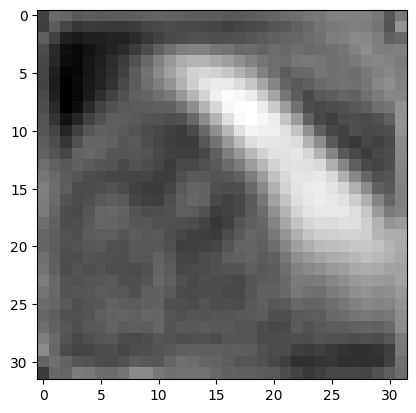

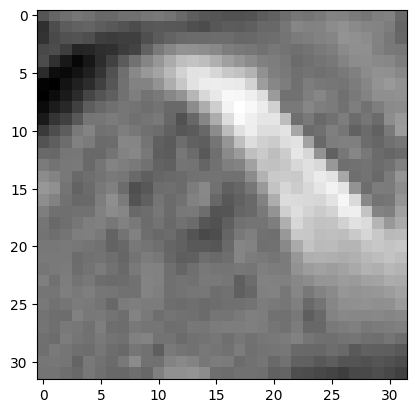

In [15]:
i = 60 
j = 60
k = 80

channel = 1

lr_patch = np.copy(subjects_lr[6][
                        i - p_size_i - e_or_o : i + p_size_i,
                        j - p_size_i - e_or_o : j + p_size_i,
                        k - p_size_i - e_or_o : k + p_size_i, :])

hr_patch = np.copy(subjects_hr[6][
                        i - p_size_o - e_or_o : i + p_size_o,
                        j - p_size_o - e_or_o : j + p_size_o,
                        k - p_size_o - e_or_o : k + p_size_o, :])

lr_mask = subjects_masks[6][
                            i - p_size_i - e_or_o : i + p_size_i,
                            j - p_size_i - e_or_o : j + p_size_i,
                            k - p_size_i - e_or_o : k + p_size_i]

lr_patch[lr_mask == 0] = 0

generated_image = model_unet(lr_patch[None,...], training=False)

plt.imshow(generated_image[0,:,:,3,channel],cmap='gray')
plt.figure()
plt.imshow(hr_patch[:,:,3,channel],cmap='gray')

In [16]:
# subjects_lr
# subjects_hr# subjects_masks

result_image = np.zeros(hires_output.shape)

for (i, j, k) in tqdm(sel_indices[np.where(sel_indices[:,0]==6),1:].squeeze()):

    lr_patch = np.copy(subjects_lr[6][
                            i - p_size_i - e_or_o : i + p_size_i,
                            j - p_size_i - e_or_o : j + p_size_i,
                            k - p_size_i - e_or_o : k + p_size_i, :])

    lr_mask = subjects_masks[6][
                                i - p_size_i - e_or_o : i + p_size_i,
                                j - p_size_i - e_or_o : j + p_size_i,
                                k - p_size_i - e_or_o : k + p_size_i]

    lr_patch[lr_mask == 0] = 0

    output_patch = model_unet(lr_patch[None,...], training=False)

    result_image[i - p_size_o - e_or_o : i + p_size_o,
                 j - p_size_o - e_or_o : j + p_size_o,
                 k - p_size_o - e_or_o : k + p_size_o, :] = output_patch

result_image[subjects_masks[6] == 0] = 0
    

100%|███████████████████████████████████████████| 65/65 [00:02<00:00, 26.80it/s]


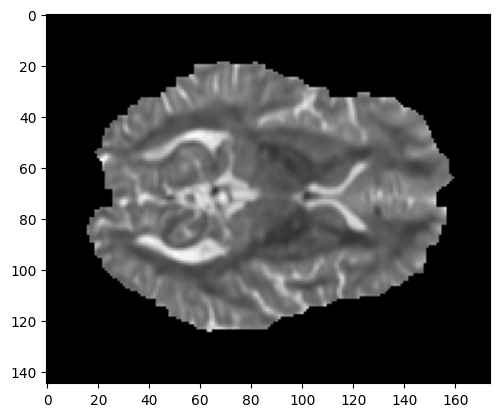

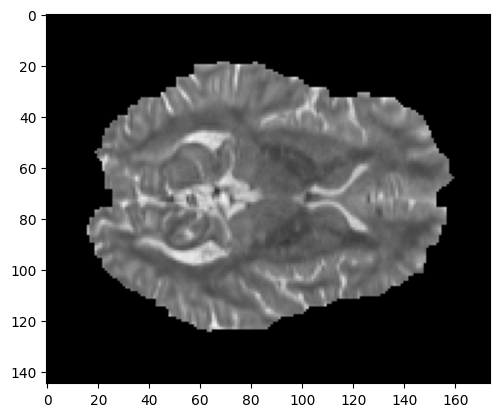

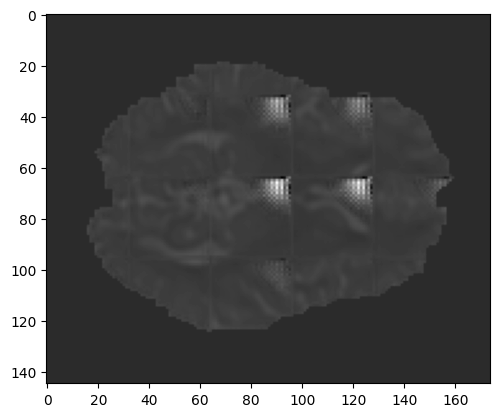

In [17]:
zdim = 60
channel = 0

# plt.imshow(subjects_masks[6][:,:,zdim], cmap='gray')
# plt.figure()
plt.imshow(subjects_lr[6][:,:,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(subjects_hr[6][:,:,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(result_image[:,:,zdim,channel], cmap='gray')

0.1314642606296684 0.15640600571427601 -0.8236386775970459


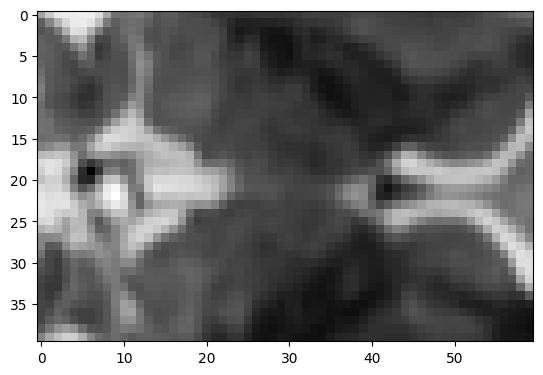

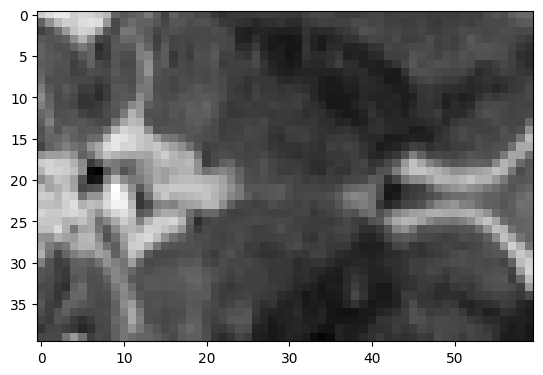

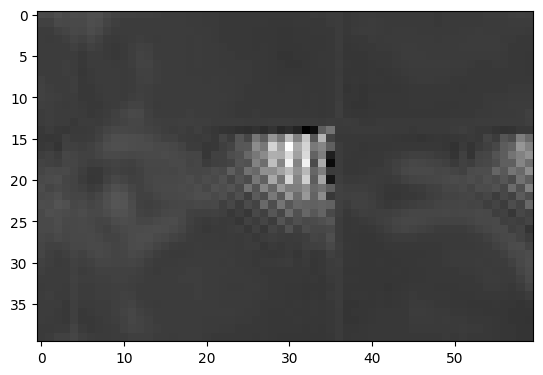

In [18]:
plt.imshow(subjects_lr[6][50:90,60:120,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(subjects_hr[6][50:90,60:120,zdim,channel], cmap='gray')
plt.figure()
plt.imshow(result_image[50:90,60:120,zdim,channel], cmap='gray')

print(np.min(subjects_lr[6][40:80,60:120,zdim,channel]), np.min(subjects_hr[6][40:80,60:120,zdim,channel]), np.min(result_image[40:80,60:120,zdim,channel]))

In [19]:
# generator.save_weights('Model/gen_weights')
# discriminator.save_weights('Model/disc_weights')

In [20]:
model_unet.save('Model/unet_model')

INFO:tensorflow:Assets written to: Model/unet_model/assets


INFO:tensorflow:Assets written to: Model/unet_model/assets
